# Imports

In [4]:
import pandas as pd

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import accuracy_score 
import plot_utils
from statistics import mean 

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Read Data Set

In [5]:
df = pd.read_csv("featured_data_with_fixed_time.csv")
df = df.drop('total_time', axis=1, errors='ignore') 
df = df.drop('session_id', axis=1, errors='ignore') 
df = df.drop('scenario', axis=1, errors='ignore') 
df = df.drop('pedId', axis=1, errors='ignore') 
df = df.drop('speed_react', axis=1, errors='ignore') 
df = df.drop('distancePed', axis=1, errors='ignore') 
df = df.drop('speed_react', axis=1, errors='ignore') 
df = df.drop('reaction_time', axis=1, errors='ignore') 
df = df.drop('pedestriansLevel', axis=1, errors='ignore') 
df = df.drop('visibilityLevel', axis=1, errors='ignore') 
df = df.drop('trafficLevel', axis=1, errors='ignore') 
pd.options.display.max_columns = None
df.head()

speed_total_mean  steering_total_mean  brake_total_mean  \
0          6.978462             0.493644          0.947244   
1          7.045599             0.504890          0.875541   
2         10.263041             0.478319          0.817679   
3          7.264644             0.514681          0.801175   
4          9.494161             0.505996          0.653854   

   throttle_total_mean  acceleration_total_mean  speed_total_var  \
0             0.813465                -0.000623        13.607109   
1             0.911211                -0.045255        33.663919   
2             0.595013                -0.017068        76.873997   
3             0.653184                -0.039171        54.852313   
4             0.808684                -0.143883        87.900514   

   steering_total_var  brake_total_var  throttle_total_var  \
0            0.000420         0.021339            0.032907   
1            0.000176         0.065360            0.002429   
2            0.001610         0.105119            0.076302   
3            0.000417         0.031045            0.038022   
4            0.000130         0.106531            0.056698   

   acceleration_total_var  max_speed       PKE  PKE_Steering  hadCollision  
0                0.050404  11.669766  1.105975 -1.848506e+06             0  
1                0.068962  13.499710  0.077727  0.000000e+00             0  
2                0.705761  25.851397  5.013003  6.996196e+05             1  
3                0.079587  20.067612  4.199223 -2.257110e+06             1  
4                0.141090  29.754023  1.505738  7.974151e+05             1

### Distribution of cases

In [6]:
num_obs = len(df)
num_true = len(df.loc[df['hadCollision'] == 1])
num_false = len(df.loc[df['hadCollision'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  34 (7.49%)
Number of False cases: 420 (92.51%)


We have considerably more false cases than true ones.

# Predictions

First I will start with the DecisionTree that made the feature importances plot.

### Auxiliar function for random repeats

In [7]:
from sklearn.model_selection import train_test_split
data = df.copy()
X = data.drop('hadCollision', axis=1) 
Y = data['hadCollision']

def default_train_test_split(test_size):
    return train_test_split(X, Y, test_size=test_size, stratify=Y)

def repite_model_predict_algorithm( fit_function, predict_function, repetitions=50, test_size=0.4, split_fuction=default_train_test_split):
    y_pred_total = []
    y_test_total = []
    for i in range(repetitions):
        X_train, X_test, y_train, y_test = split_fuction(test_size)
        fit_function(X_train, y_train)
        y_pred = predict_function(X_test)
        y_pred_total.append(y_pred)
        y_test_total.append(y_test)
    
    plot_utils.print_header("Multiple experiments average result:")
    summarize_multiple_experiments_average_results(y_test_total, y_pred_total)
    
    plot_utils.print_header("Sum of all experiments results:")
    summarize_one_big_experiment_results(y_test_total, y_pred_total)

def summarize_multiple_experiments_average_results(y_test_total, y_pred_total):
    total_acc, no_hit_prec, no_hit_rec, no_hit_fscore, hit_prec, hit_rec, hit_fscore, kappa = ([] for i in range(8))
    for y_true,y_pred in zip(y_test_total, y_pred_total):
        cr = metrics.classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        total_acc.append(cr['accuracy']*100)
        no_hit_prec.append(cr['0']['precision'])
        no_hit_rec.append(cr['0']['recall'])
        no_hit_fscore.append(cr['0']['f1-score'])
        hit_prec.append(cr['1']['precision'])
        hit_rec.append(cr['1']['recall'])
        hit_fscore.append(cr['1']['f1-score'])
        kappa.append(metrics.cohen_kappa_score(y_true, y_pred, labels=None, weights=None))
    print("Total Accuracy: %{0:.2f}".format(average(total_acc)))
    print("Cohen's kappa coefficient: {0:.2f}".format(average(kappa)))
    means = [[average(no_hit_prec), average(no_hit_rec), average(no_hit_fscore)], 
             [average(hit_prec), average(hit_rec), average(hit_fscore)]]
    plot_utils.plot_classification_report_means(means)
    plot_utils.plot_confusion_matrix([[average(no_hit_rec), 1 - average(no_hit_rec)],
                                      [1 - average(hit_rec), average(hit_rec)]])
    plot_utils.print_result(average(kappa))
    plot_utils.print_result(average(total_acc), 92.31, "Total Accuracy percentaje", '%')
    plot_utils.print_result(average(hit_prec), 0, "Hit Precision")
    plot_utils.print_result(average(hit_rec), 0, "Hit Recall")
    plot_utils.print_result(average(no_hit_prec), 0.92, "No Hit Precision")
    plot_utils.print_result(average(no_hit_rec), 1, "No Hit Recall")
    
def average(values):
    return round(mean(values), 2)
    
def summarize_one_big_experiment_results(y_test_total, y_pred_total):
    y_test_total = [val for sublist in y_test_total for val in sublist]
    y_pred_total = [val for sublist in y_pred_total for val in sublist]
    lookup = {0: 'No Hit', 1:'Yes Hit'}
    y_true_pd = pd.Series([lookup[_] for _ in y_test_total])
    y_pred_pd = pd.Series([lookup[_] for _ in y_pred_total])
    

    print("Confusion Matrix")
    print("")
    tab = pd.crosstab(y_true_pd, y_pred_pd, rownames=['True'], colnames=['Predicted'], margins=False)

    print(tab)
    print("")    

## Zero Rule Baseline (All No Recurrence)

In [8]:
# zero rule algorithm for classification
def zero_rule_algorithm_fit(train, test):
    #DO NOTHING
    pass

def zero_rule_algorithm_classification(test):
    prediction = 0
    predicted = [prediction for i in range(len(test))]
    return predicted

repite_model_predict_algorithm(zero_rule_algorithm_fit, zero_rule_algorithm_classification, 100, 0.4)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %92.31
Cohen's kappa coefficient: 0.00


Cohen's kappa coefficient is same as the baseline:  0.0

Total Accuracy percentaje is same as the baseline: % 92.31

Hit Precision is same as the baseline:  0.0

Hit Recall is same as the baseline:  0.0

No Hit Precision is same as the baseline:  0.92

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit
True             
No Hit      16800
Yes Hit      1400



## Decision Tree

In [9]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.4)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.62
Cohen's kappa coefficient: 0.25


Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.69</span> below the baseline.

Hit Precision is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      79425     4575
Yes Hit      4873     2127



As we can see we have a good 'Total Accuracy' of 92 % and a good recall for false cases. The problem here is that it seems to be an overfitting given that the algorithm assert with almost the 96% false cases but when it is a true case we have around 48%. 

I decided to add two pie plots only to visualize the recall of both decisions, and in particular to show falses negatives percentage. In a real case we would try to avoid those negatives cases in order to avoid when the model predict that it will not be collision but it finally happens.

Regarding that, we can consider that the fact of having less true cases for training the model may be a problem for this investigation. However, we will try to see different approachs with the same data to deal with that.

As we can see in the Confusion Matrix we have almost 15 k true cases and we only predict almost 7k correctly.

Also this problem is repeated with 0.1, 0.2, 0.3 and 0.5 test_size.

## KNN classifier

### Search for best n neighbors number

In [10]:
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 10)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, Y)
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 4}

### KNN classifier with n=4

<h3>Multiple experiments average result:</h3>

Total Accuracy: %92.57
Cohen's kappa coefficient: -0.00


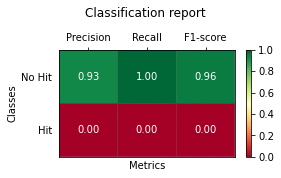

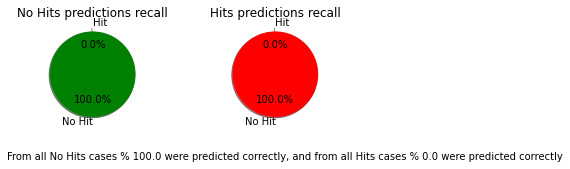

Cohen's kappa coefficient is same as the baseline:  -0.0

Total Accuracy percentaje is <span style="color:green">% +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is same as the baseline:  0.0

Hit Recall is same as the baseline:  0.0

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      12682       18
Yes Hit      1000        0



In [11]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 100, 0.3)

This case is a clear example of overfitting. We have a huge percentage of correct 'No Hit Predictions' but the opposite with 'Hit predictions'. The model seems to be used to predict that the driver it's not going to crash which translates into a high percentage of false negatives cases.

I used 20% of data set for testing, because performs better in this case.

## Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.20
Cohen's kappa coefficient: 0.24


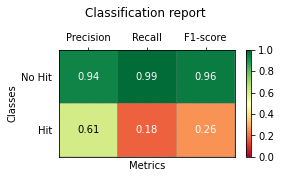

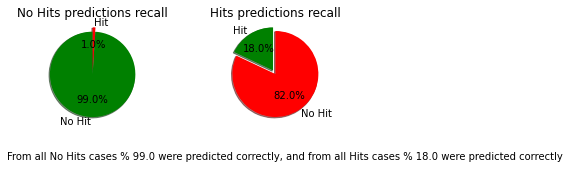

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +0.89</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.61</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.01</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      62967      533
Yes Hit      4123      877



In [12]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)

The same problem can be seen with this model, the best recall achieved was %30 trying with different training sizes.

# Over sampling data

Now we will try increasing the numbers of true cases with different over sampling approachs:

## Random Over Sampler

In [13]:
from imblearn.over_sampling import RandomOverSampler

def random_over_sampler_split(test_size):
    ros = RandomOverSampler()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    #X_resampled, y_resampled = X_train, y_train
    return X_resampled, X_test, y_resampled, y_test

def print_over_sampling_fuction(split_function, test_size):
    X_resampled, X_test, y_resampled, y_test = split_function(test_size)
    print_split_data_set(X_resampled, X_test, y_resampled, y_test)

In [14]:
def print_split_data_set(X_train, X_test, y_train, y_test):
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))
    
print_over_sampling_fuction(random_over_sampler_split, 0.4)

Training True  : 252 (50.00%)
Training False : 252 (50.00%)

Test True      : 14 (7.69%)
Test False     : 168 (92.31%)


Here we can see that False cases were splitted normally and "Training True" cases are now equals to falses.

### Decision Tree

This algorith was ignore because results were worst than before (without over sampling data)

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.29
Cohen's kappa coefficient: 0.04


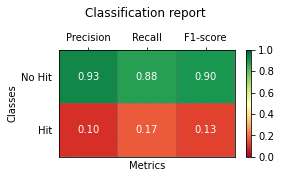

Cohen's kappa coefficient is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.02</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      73703    10297
Yes Hit      5821     1179



In [15]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 500, 0.4, random_over_sampler_split)

With over sampling Knn seems to be better at recall, but it lose a lot of precision comparing without over sampling data.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.33
Cohen's kappa coefficient: 0.31


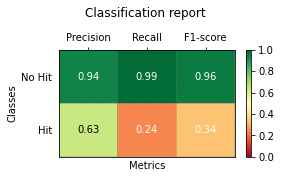

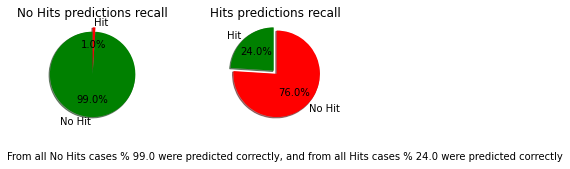

Cohen's kappa coefficient is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +1.02</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.63</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.01</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      62713      787
Yes Hit      3780     1220



In [16]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3, random_over_sampler_split)

For random forest there is no difference with random over sampling data.

## SMOTE

In [17]:
from imblearn.over_sampling import SMOTE, ADASYN

def smote_over_sampler_split(test_size):
    smote = SMOTE()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = smote.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(smote_over_sampler_split, 0.4)

Training True  : 252 (50.00%)
Training False : 252 (50.00%)

Test True      : 14 (7.69%)
Test False     : 168 (92.31%)


### Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.65
Cohen's kappa coefficient: 0.16


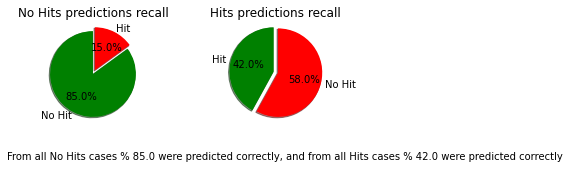

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.66</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.42</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      53845     9655
Yes Hit      2913     2087



In [18]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.3, smote_over_sampler_split)

Decision Tree doesn't change results with over sampling data.

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %62.02
Cohen's kappa coefficient: 0.03


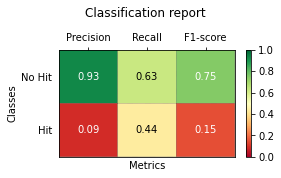

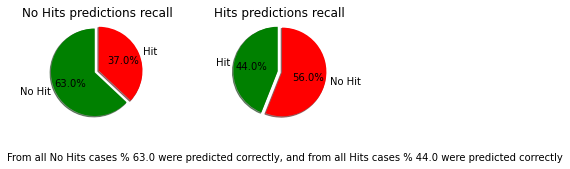

Cohen's kappa coefficient is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -30.29</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.44</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.37</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      26663    15337
Yes Hit      1943     1557



In [19]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 500, 0.2, smote_over_sampler_split)

With Smote we have better Recall but worst precision.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.67
Cohen's kappa coefficient: 0.28


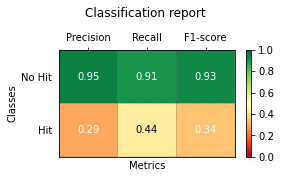

Cohen's kappa coefficient is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.64</span> below the baseline.

Hit Precision is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.44</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.09</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      57837     5663
Yes Hit      2785     2215



In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3, smote_over_sampler_split)

This are similars results as Randon Forest without over sampling, but with a considerable worst precision. It is still possible to notice the overfitting.

## ADASYN

In [21]:
def adasyn_over_sampler_split(test_size):
    adasyn = ADASYN()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = adasyn.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(adasyn_over_sampler_split, 0.4)

Training True  : 252 (50.00%)
Training False : 252 (50.00%)

Test True      : 14 (7.69%)
Test False     : 168 (92.31%)


This oversampling it's not totally exactly when doing the true training cases. So it's not exactly 50% of each.

### Decision Tree

Ignored

### KNN classifier

<h3>Multiple experiments average result:</h3>

Total Accuracy: %60.87
Cohen's kappa coefficient: 0.03


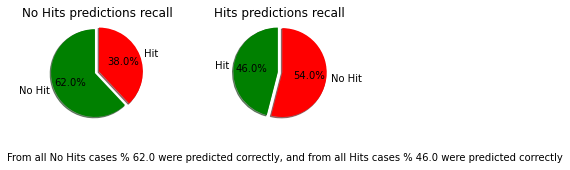

Cohen's kappa coefficient is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -31.44</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.46</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.38</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      39386    24114
Yes Hit      2691     2309



In [22]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 500, 0.3, adasyn_over_sampler_split)

Similar recall to Smote but worst precision.

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.56
Cohen's kappa coefficient: 0.28


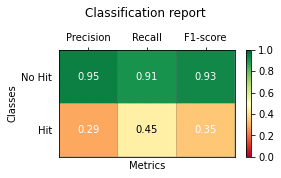

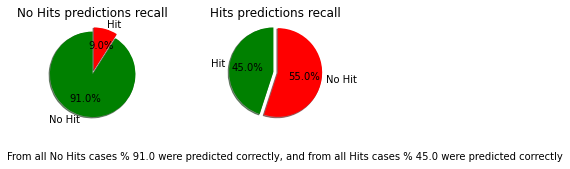

Cohen's kappa coefficient is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.75</span> below the baseline.

Hit Precision is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.45</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.09</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      57712     5788
Yes Hit      2734     2266



In [23]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3, adasyn_over_sampler_split)

Worst results than smote and no over sampling.

# Changing training data

I will try training the data with the same numbers of false cases and true cases but this time with less false cases:

In [24]:
def equal_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives)

def double_false_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives*2)

size = 3
def global_false_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives*size)

def split_cases(positive_training_size, negative_training_size):
    positives = data.loc[df['hadCollision'] == 1].copy()
    negatives = data.loc[df['hadCollision'] == 0].copy()
    test_size_pos = len(positives) - positive_training_size
    test_size_neg = len(negatives) - negative_training_size

    X_train_pos, X_test_pos = train_test_split(positives, train_size=positive_training_size, test_size=test_size_pos)
    X_train_neg, X_test_neg = train_test_split(negatives, train_size=negative_training_size, test_size=test_size_neg)
    X_train_total = X_train_pos.append(X_train_neg)
    X_test_total = X_test_pos.append(X_test_neg)

    X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
    X_test_total = X_test_total.sample(frac=1).reset_index(drop=True)
    X_train = X_train_total.drop('hadCollision', axis=1) 
    y_train = X_train_total['hadCollision']

    X_test = X_test_total.drop('hadCollision', axis=1) 
    y_test = X_test_total['hadCollision']
    return X_train, X_test, y_train, y_test

def print_results_with_size(split_function, train_size_pos):
    X_train, X_test, y_train, y_test = split_function(train_size_pos)
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))

In [25]:
print_results_with_size(equal_cases_split, 28)

Training True  : 28 (50.00%)
Training False : 28 (50.00%)

Test True      : 6 (1.51%)
Test False     : 392 (98.49%)


We have now a training set of only 60 cases with 50% hits and 50% no hits. I decided to take 30 true cases as it's almost de 80% of true cases for training.

### Decision Tree

<h3>Multiple experiments average result:</h3>

Total Accuracy: %68.37
Cohen's kappa coefficient: 0.04


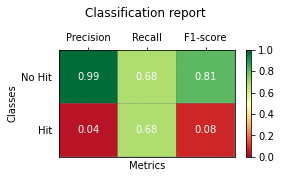

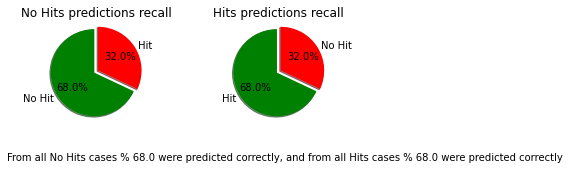

Cohen's kappa coefficient is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -23.94</span> below the baseline.

Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.32</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     134712    62288
Yes Hit      1285     2715



In [26]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 500, 26, equal_cases_split)

The recall is strongly increased with this approach, but now the "No hit" predictions are not as good as before and that makes a presicion for "Yes Hit"'s cases really bad due to compare 5k correct predictions with more than 100k false positives.

In [27]:
size = 4
print_results_with_size(global_false_cases_split, 20)

Training True  : 20 (20.00%)
Training False : 80 (80.00%)

Test True      : 14 (3.95%)
Test False     : 340 (96.05%)


Trying with the double of false cases for training in order to get more precision of "Yes Hit" cases, but this time taking only 20 true cases for training.

<h3>Multiple experiments average result:</h3>

Total Accuracy: %78.59
Cohen's kappa coefficient: 0.07


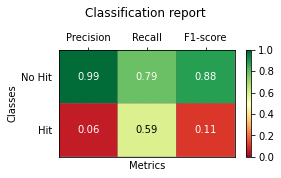

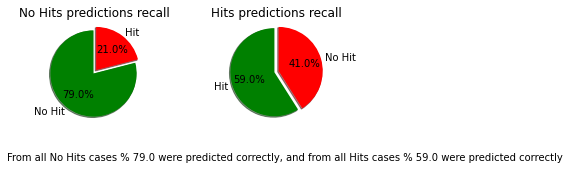

Cohen's kappa coefficient is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -13.72</span> below the baseline.

Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.59</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.21</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     145392    38608
Yes Hit      1651     2349



In [28]:
clf = tree.DecisionTreeClassifier()
size = 2
repite_model_predict_algorithm(clf.fit, clf.predict, 500, 26, global_false_cases_split)

We could increase the recall of "No Hit", which affects to "Yes Hit" precision on almost the triple, but is still low. 

### Knn

<h3>Multiple experiments average result:</h3>

Total Accuracy: %56.01
Cohen's kappa coefficient: 0.00


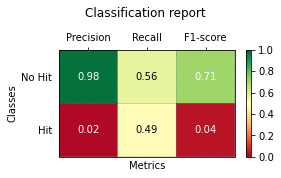

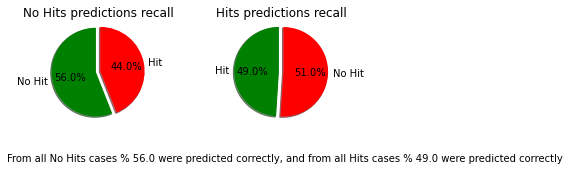

Cohen's kappa coefficient is same as the baseline:  0.0

Total Accuracy percentaje is <span style="color:red">% -36.3</span> below the baseline.

Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.49</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.44</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     110610    86390
Yes Hit      2029     1971



In [29]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 500,  26, equal_cases_split)

Worst metrics as before

<h3>Multiple experiments average result:</h3>

Total Accuracy: %76.39
Cohen's kappa coefficient: 0.01


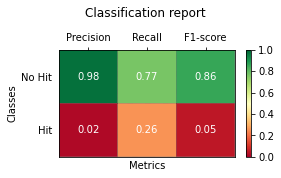

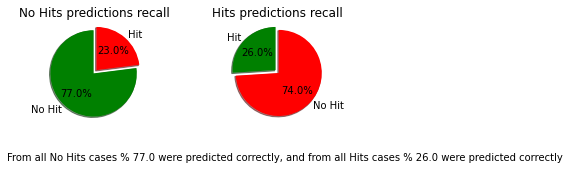

Cohen's kappa coefficient is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -15.92</span> below the baseline.

Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.23</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     142552    41448
Yes Hit      2943     1057



In [30]:
knn = KNeighborsClassifier(n_neighbors = 3)

repite_model_predict_algorithm(knn.fit, knn.predict, 500,  26, double_false_cases_split)

We recorver the recall of "No Hits" predictions but it's not enougth to have good precision of "Yes Hit"

### Random Forest

<h3>Multiple experiments average result:</h3>

Total Accuracy: %76.63
Cohen's kappa coefficient: 0.08


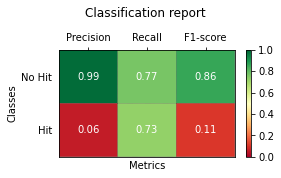

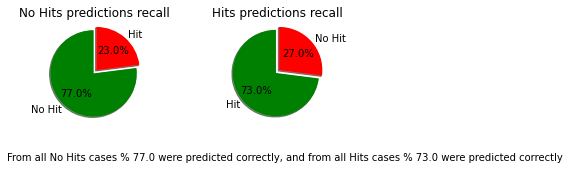

Cohen's kappa coefficient is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -15.68</span> below the baseline.

Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.23</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     151107    45893
Yes Hit      1085     2915



In [31]:
rf_model = RandomForestClassifier()

repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 26, equal_cases_split)

The recall it's considerable better with this configuration. However the model now seems to see a lot of cases positives than before. This doesn't affect "No hit" precision or recall, but the precision of "Yes Hit" cases it's considerable worst than before. This means we have now a lot of False Positive cases.

We can see in the confusion matrix that almost 72k cases were predicted with a collision and there were false hits. In real life this will be a problem because we would be alerting for nothing really, but in fact it is not as important as the opposite case.

<h3>Multiple experiments average result:</h3>

Total Accuracy: %88.29
Cohen's kappa coefficient: 0.16


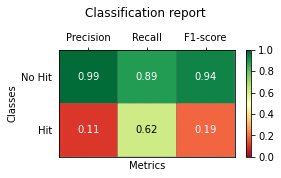

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.02</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.62</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.11</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     163498    20502
Yes Hit      1509     2491



In [32]:
rf_model = RandomForestClassifier()
size = 2
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 26, global_false_cases_split)

There is an improvement with the precision of "Yes Hit" but still low. On the other hand, the recall of "Yes Hit" it's not as good as before, but in the combination of both (f1-score) this is a better configuration.

The preference on the result will depend on the weigth of those classes.

# Weights classes

## Balanced

### Decision Tree

In [33]:
clf = tree.DecisionTreeClassifier(class_weight='balanced')

repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.2)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.50
Cohen's kappa coefficient: 0.23


Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.81</span> below the baseline.

Hit Precision is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      39744     2256
Yes Hit      2522      978



<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.52
Cohen's kappa coefficient: 0.24


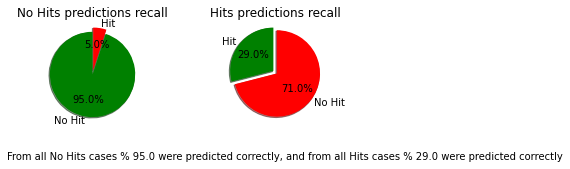

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.79</span> below the baseline.

Hit Precision is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      39716     2284
Yes Hit      2485     1015



In [34]:
clf = tree.DecisionTreeClassifier(class_weight={0:1, 1:9})

repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.2)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.12
Cohen's kappa coefficient: 0.26


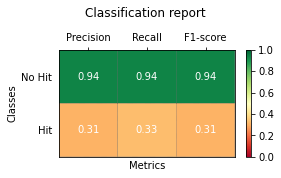

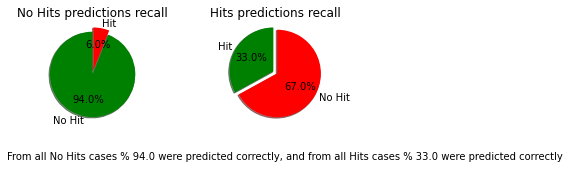

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -3.19</span> below the baseline.

Hit Precision is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.06</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      39380     2620
Yes Hit      2330     1170



In [35]:
clf = tree.DecisionTreeClassifier(class_weight={0:9, 1:1})

repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.2)

Worst than default case.

### KNN

Default value is 'uniform' or balance, so I will try with distance

<h3>Multiple experiments average result:</h3>

Total Accuracy: %87.38
Cohen's kappa coefficient: 0.01


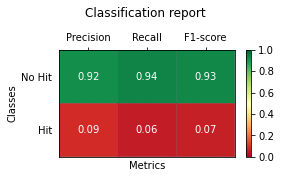

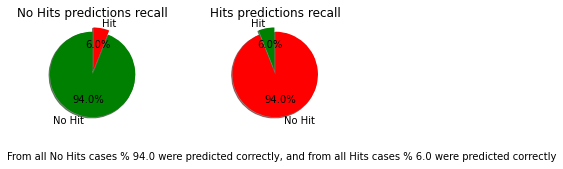

Cohen's kappa coefficient is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -4.93</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is same as the baseline:  0.92

No Hit Recall is <span style="color:red"> -0.06</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      39537     2463
Yes Hit      3280      220



In [36]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

repite_model_predict_algorithm(knn.fit, knn.predict, 500,  0.2)

Same overfitting as default case

### Random Forest

#### Balanced

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.08
Cohen's kappa coefficient: 0.13


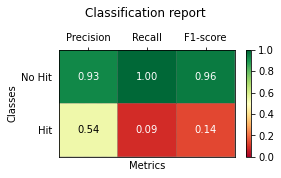

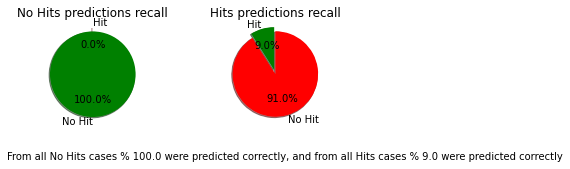

Cohen's kappa coefficient is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +0.77</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.54</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      63332      168
Yes Hit      4572      428



In [37]:
rf_model = RandomForestClassifier(class_weight="balanced")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.11
Cohen's kappa coefficient: 0.13


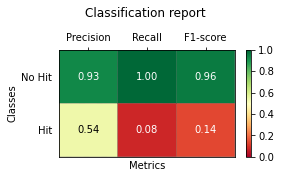

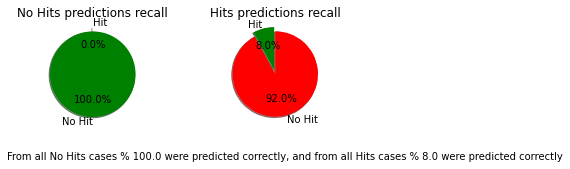

Cohen's kappa coefficient is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +0.8</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.54</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      63361      139
Yes Hit      4584      416



In [38]:
rf_model = RandomForestClassifier(class_weight={0:1, 1:9})
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)

In [39]:
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)

<h3>Multiple experiments average result:</h3>

Total Accuracy: %92.81
Cohen's kappa coefficient: 0.27


Cohen's kappa coefficient is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +0.5</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.54</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.02</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      62447     1053
Yes Hit      3869     1131



Same overfitting as default.

#### Balanced Subsample

<h3>Multiple experiments average result:</h3>

Total Accuracy: %93.06
Cohen's kappa coefficient: 0.12


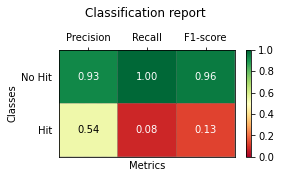

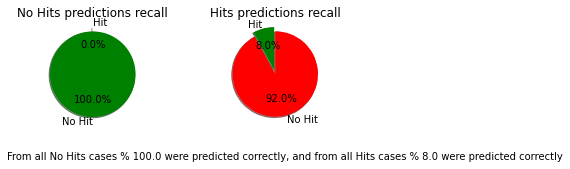

Cohen's kappa coefficient is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.54</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.01</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is same as the baseline:  1.0

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      63349      151
Yes Hit      4603      397



In [40]:
rf_model = RandomForestClassifier(class_weight="balanced_subsample")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)

Same overfitting as default

### Decision Tree

In [41]:
from IPython.core.display import display, Markdown

def print_header(header):
    raw_html = "<h3>"+header+"</h3>"
    display( Markdown(raw_html) )

<h3>Running: Default model-prediction</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.18
Cohen's kappa coefficient: 0.26


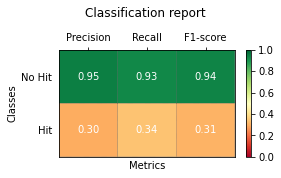

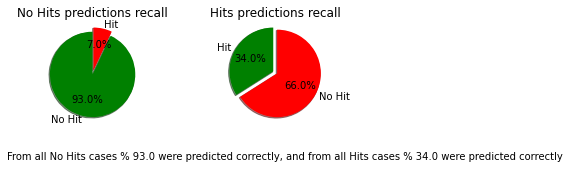

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -3.13</span> below the baseline.

Hit Precision is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.34</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.07</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      59362     4138
Yes Hit      3276     1724



<h3>Running: Random Over Sampler</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %89.93
Cohen's kappa coefficient: 0.27


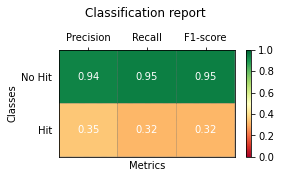

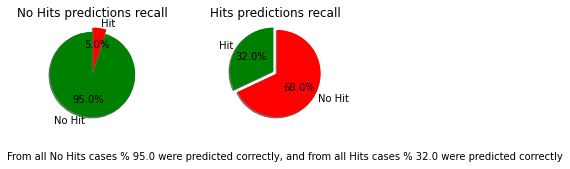

Cohen's kappa coefficient is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -2.38</span> below the baseline.

Hit Precision is <span style="color:green"> +0.35</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.05</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      39797     2203
Yes Hit      2380     1120



<h3>Running: SMOTE</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.84
Cohen's kappa coefficient: 0.22


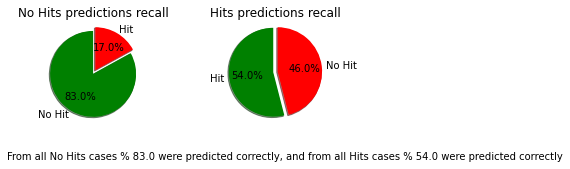

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.47</span> below the baseline.

Hit Precision is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.54</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      34893     7107
Yes Hit      1610     1890



<h3>Running: ADASYN</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.56
Cohen's kappa coefficient: 0.22


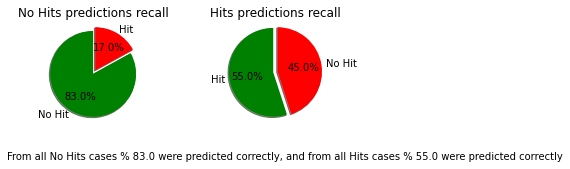

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.75</span> below the baseline.

Hit Precision is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.55</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.04</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      34717     7283
Yes Hit      1564     1936



<h3>Running: Equal training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %65.94
Cohen's kappa coefficient: 0.07


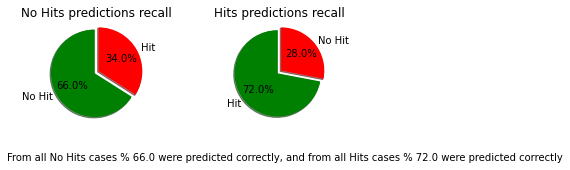

Cohen's kappa coefficient is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -26.37</span> below the baseline.

Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.34</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     131456    68544
Yes Hit      1956     5044



<h3>Running: Double false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %76.47
Cohen's kappa coefficient: 0.11


Cohen's kappa coefficient is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -15.84</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.63</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.23</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     146224    43776
Yes Hit      2579     4421



<h3>Running: Triple false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %76.33
Cohen's kappa coefficient: 0.11


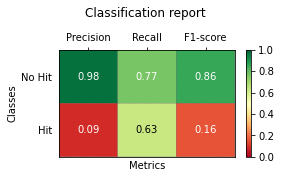

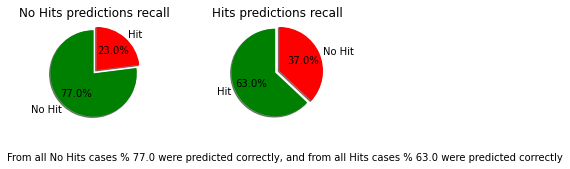

Cohen's kappa coefficient is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -15.98</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.63</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.23</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     145955    44045
Yes Hit      2579     4421



In [42]:
def run_all_models(clf):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.3)

    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.2, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.2, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 0.2, adasyn_over_sampler_split)

    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 20, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 20, double_false_cases_split)
    
    print_header("Running: Triple false training cases")
    size = 3
    repite_model_predict_algorithm(clf.fit, clf.predict, 500, 20, global_false_cases_split)
    
clf = tree.DecisionTreeClassifier(class_weight={0:10, 1:1})
run_all_models(clf)

Regarding Hits predictions recall we can see a really good performance with "Equal training cases" but again still a bad precision for this class. 

Regarding F1-score, it means seen precision and recall, we acceptable performances with Smote and Random over samplers, and with default case we have a similar performance in each component.

### Knn

I didn't find Knn class_weigths, it has a function weigth but I think is only weigths per feature:
    
    - [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

### Random Forest

<h3>Running: Default model-prediction</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %92.97
Cohen's kappa coefficient: 0.29


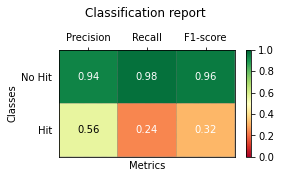

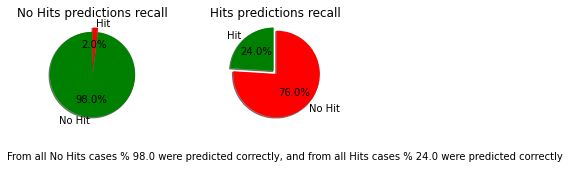

Cohen's kappa coefficient is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +0.66</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.56</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.02</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.02</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      62506      994
Yes Hit      3819     1181



<h3>Running: Random Over Sampler</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %92.84
Cohen's kappa coefficient: 0.39


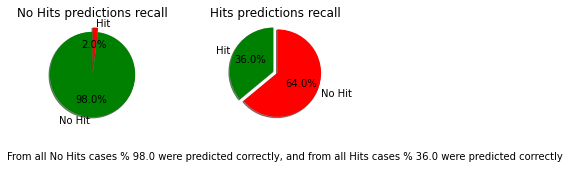

Cohen's kappa coefficient is <span style="color:green"> +0.39</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:green">% +0.53</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Precision is <span style="color:green"> +0.57</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.36</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.03</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.02</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      40987     1013
Yes Hit      2245     1255



<h3>Running: SMOTE</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.47
Cohen's kappa coefficient: 0.32


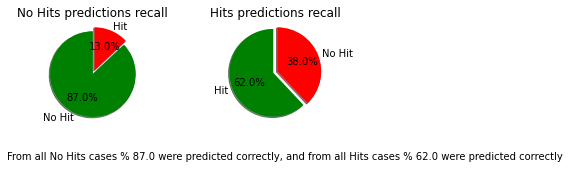

Cohen's kappa coefficient is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.84</span> below the baseline.

Hit Precision is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.62</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      55420     8080
Yes Hit      1875     3125



<h3>Running: ADASYN</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.80
Cohen's kappa coefficient: 0.33


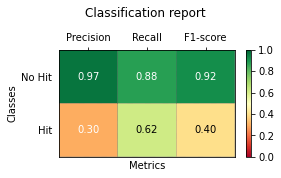

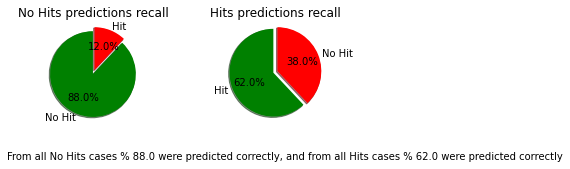

Cohen's kappa coefficient is <span style="color:green"> +0.33</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.51</span> below the baseline.

Hit Precision is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.62</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      73722    10278
Yes Hit      2646     4354



<h3>Running: Equal training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %73.10
Cohen's kappa coefficient: 0.11


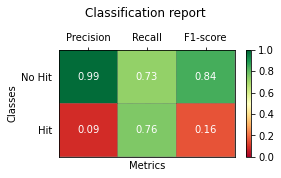

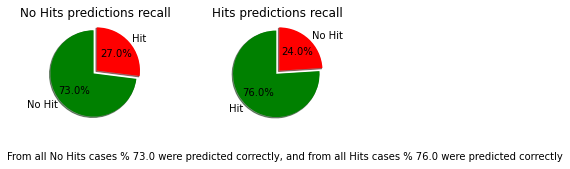

Cohen's kappa coefficient is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -19.21</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.76</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.27</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     146034    53966
Yes Hit      1708     5292



<h3>Running: Double false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.24
Cohen's kappa coefficient: 0.20


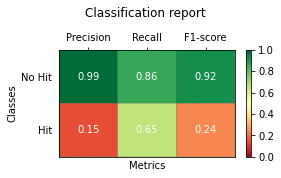

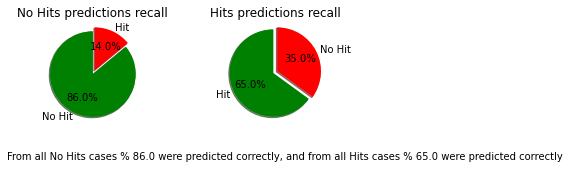

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.07</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.65</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     163362    26638
Yes Hit      2445     4555



<h3>Running: Triple false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.93
Cohen's kappa coefficient: 0.19


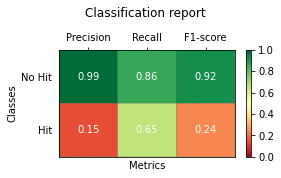

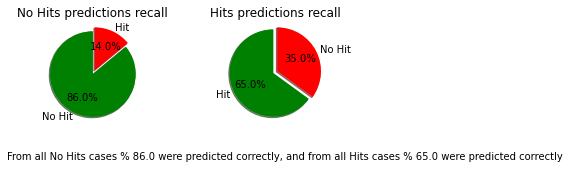

Cohen's kappa coefficient is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.38</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.65</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     162750    27250
Yes Hit      2441     4559



In [43]:
def run_all_models(rf_model):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3)
    
    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.2, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.3, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 0.4, adasyn_over_sampler_split)
    
    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 20, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 20, double_false_cases_split)
    
    print_header("Running: Triple false training cases")
    size = 3
    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 20, global_false_cases_split)
    
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})
run_all_models(rf_model)

We can see again very good recalls for Hits predictions in Equal and Double False training cases. However regarding both variables Precision and Recall, the best prediction seems to be with SMOTE over sampling having acceptables metrics in both.

<h3>Running: Equal training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %73.52
Cohen's kappa coefficient: 0.06


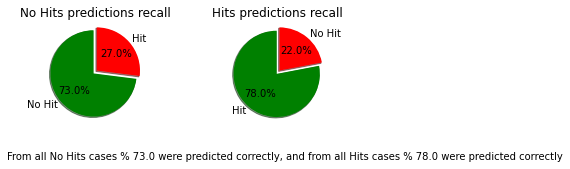

Cohen's kappa coefficient is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -18.79</span> below the baseline.

Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.78</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.27</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     144322    52178
Yes Hit       782     2718



<h3>Running: Double false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.67
Cohen's kappa coefficient: 0.12


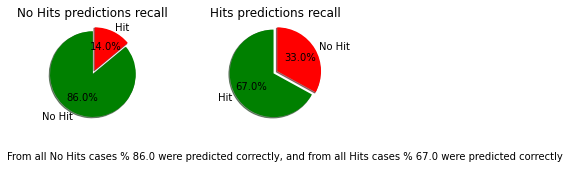

Cohen's kappa coefficient is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.64</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     157438    25562
Yes Hit      1164     2336



<h3>Running: Triple false training cases</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %90.37
Cohen's kappa coefficient: 0.18


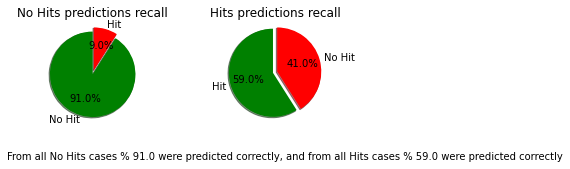

Cohen's kappa coefficient is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -1.94</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.59</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.09</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     154272    15228
Yes Hit      1434     2066



In [44]:
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

print_header("Running: Equal training cases")

repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 27, equal_cases_split)

print_header("Running: Double false training cases")

repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 27, double_false_cases_split)

print_header("Running: Triple false training cases")
size = 3
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, 27, global_false_cases_split)

## Combine split and oversampling

In [45]:
resampler = SMOTE()
size = 2

def resampler_with_split_cases(training_size_positives):

    X_train, X_test, y_train, y_test = global_false_cases_split(training_size_positives)
    X_resampled, y_resampled = resampler.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_results_with_size(resampler_with_split_cases, 27)

Training True  : 54 (50.00%)
Training False : 54 (50.00%)

Test True      : 7 (1.88%)
Test False     : 366 (98.12%)


<h3>Running: SMOTE splitting in size 2 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %76.60
Cohen's kappa coefficient: 0.13


Cohen's kappa coefficient is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -15.71</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.23</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     145685    44315
Yes Hit      1778     5222



<h3>Running: SMOTE splitting in size 3 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.32
Cohen's kappa coefficient: 0.16


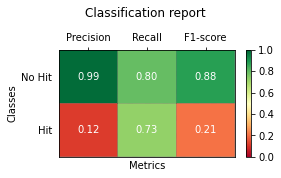

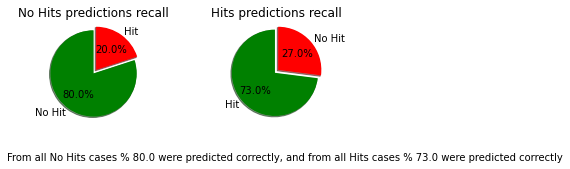

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.99</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.2</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     143233    36767
Yes Hit      1913     5087



<h3>Running: SMOTE splitting in size 4 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.13
Cohen's kappa coefficient: 0.18


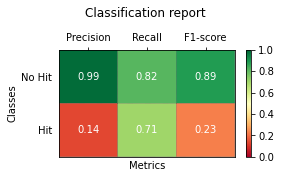

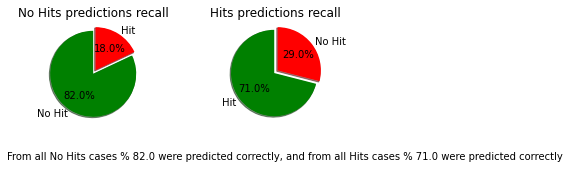

Cohen's kappa coefficient is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.18</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     138641    31359
Yes Hit      2047     4953



<h3>Running: SMOTE splitting in size 5 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.18
Cohen's kappa coefficient: 0.20


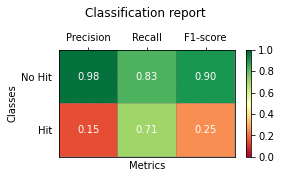

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.13</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     132300    27700
Yes Hit      2064     4936



<h3>Running: SMOTE splitting in size 6 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.28
Cohen's kappa coefficient: 0.21


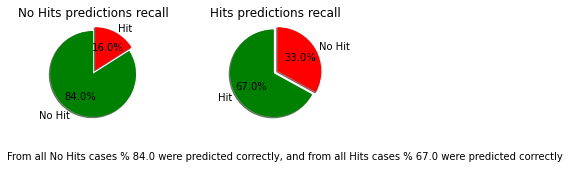

Cohen's kappa coefficient is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.03</span> below the baseline.

Hit Precision is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     126019    23981
Yes Hit      2276     4724



<h3>Running: SMOTE splitting in size 7 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.88
Cohen's kappa coefficient: 0.23


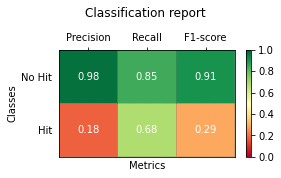

Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.43</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     118561    21439
Yes Hit      2259     4741



<h3>Running: SMOTE splitting in size 8 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.48
Cohen's kappa coefficient: 0.25


Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.83</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     111062    18938
Yes Hit      2323     4677



<h3>Running: SMOTE splitting in size 9 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.10
Cohen's kappa coefficient: 0.26


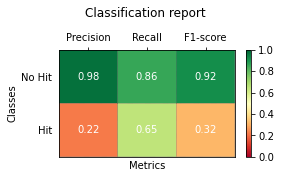

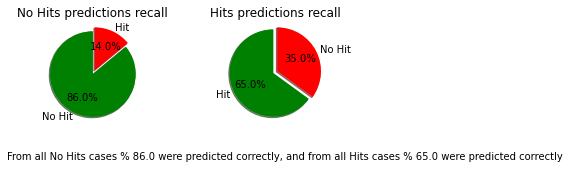

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.21</span> below the baseline.

Hit Precision is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.65</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     103558    16442
Yes Hit      2476     4524



<h3>Running: SMOTE splitting in size 10 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.32
Cohen's kappa coefficient: 0.28


Cohen's kappa coefficient is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.99</span> below the baseline.

Hit Precision is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.65</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      95298    14702
Yes Hit      2472     4528



<h3>Running: SMOTE splitting in size 11 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.62
Cohen's kappa coefficient: 0.30


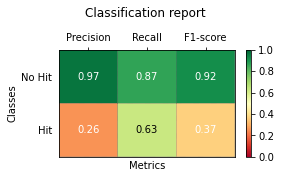

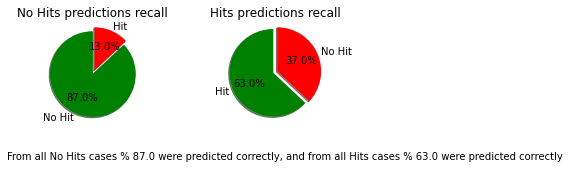

Cohen's kappa coefficient is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.69</span> below the baseline.

Hit Precision is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.63</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      87179    12821
Yes Hit      2563     4437



In [46]:
resampler = SMOTE()
positives = 20
for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: ADASYN splitting in size 2 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %76.45
Cohen's kappa coefficient: 0.13


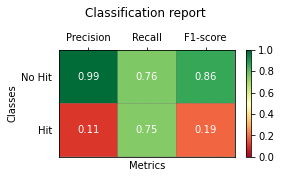

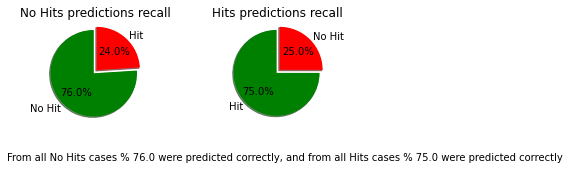

Cohen's kappa coefficient is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -15.86</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.24</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     145329    44671
Yes Hit      1721     5279



<h3>Running: ADASYN splitting in size 3 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %78.92
Cohen's kappa coefficient: 0.15


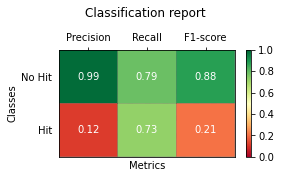

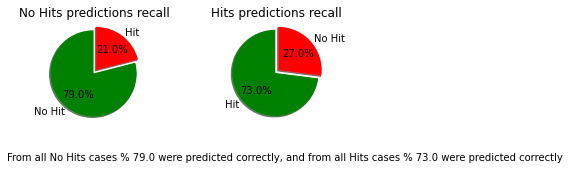

Cohen's kappa coefficient is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -13.39</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.21</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     142501    37499
Yes Hit      1915     5085



<h3>Running: ADASYN splitting in size 4 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.31
Cohen's kappa coefficient: 0.17


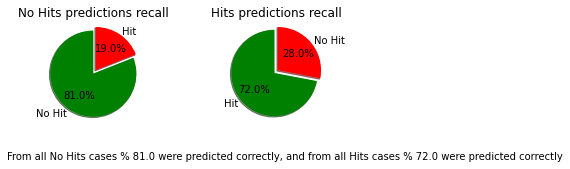

Cohen's kappa coefficient is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.0</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     137073    32927
Yes Hit      1930     5070



<h3>Running: ADASYN splitting in size 5 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.63
Cohen's kappa coefficient: 0.19


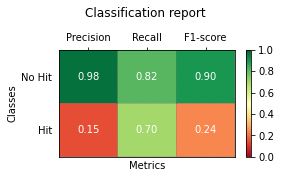

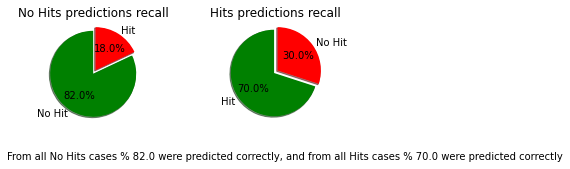

Cohen's kappa coefficient is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.68</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     131445    28555
Yes Hit      2117     4883



<h3>Running: ADASYN splitting in size 6 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.58
Cohen's kappa coefficient: 0.21


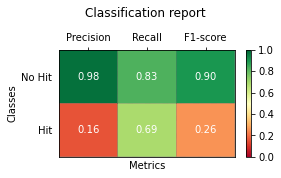

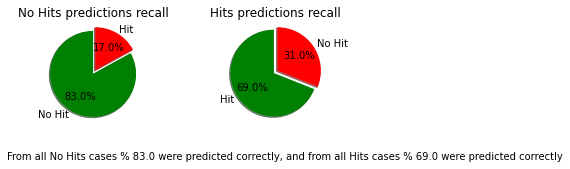

Cohen's kappa coefficient is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.73</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     124811    25189
Yes Hit      2166     4834



<h3>Running: ADASYN splitting in size 7 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.67
Cohen's kappa coefficient: 0.22


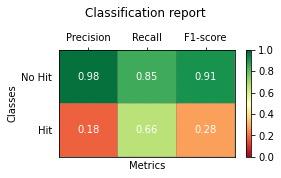

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.64</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     118358    21642
Yes Hit      2364     4636



<h3>Running: ADASYN splitting in size 8 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.31
Cohen's kappa coefficient: 0.25


Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.0</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     110814    19186
Yes Hit      2304     4696



<h3>Running: ADASYN splitting in size 9 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.98
Cohen's kappa coefficient: 0.26


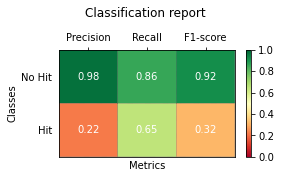

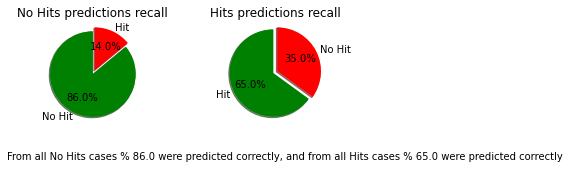

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.33</span> below the baseline.

Hit Precision is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.65</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     103372    16628
Yes Hit      2449     4551



<h3>Running: ADASYN splitting in size 10 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.15
Cohen's kappa coefficient: 0.28


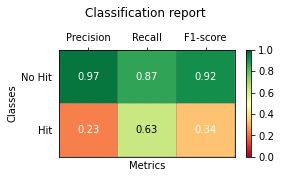

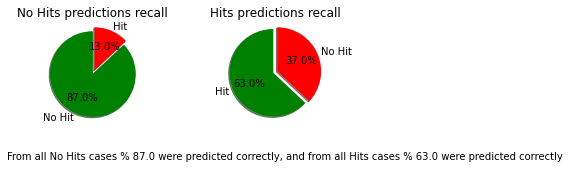

Cohen's kappa coefficient is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.16</span> below the baseline.

Hit Precision is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.63</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      95189    14811
Yes Hit      2566     4434



<h3>Running: ADASYN splitting in size 11 with positives 20</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.44
Cohen's kappa coefficient: 0.30


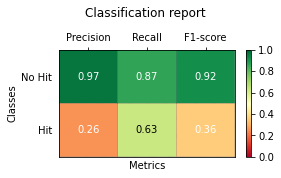

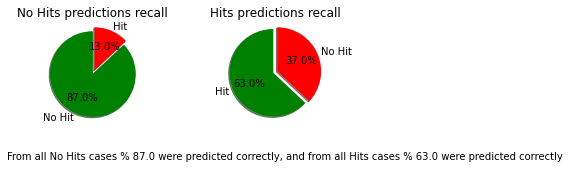

Cohen's kappa coefficient is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.87</span> below the baseline.

Hit Precision is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.63</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      87015    12985
Yes Hit      2594     4406



In [47]:
resampler = ADASYN()
positives = 20

for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: ADASYN splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: SMOTE splitting in size 2 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %77.24
Cohen's kappa coefficient: 0.11


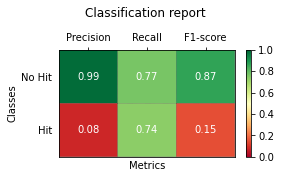

Cohen's kappa coefficient is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -15.07</span> below the baseline.

Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.23</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     143799    42201
Yes Hit      1278     3722



<h3>Running: SMOTE splitting in size 3 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.35
Cohen's kappa coefficient: 0.12


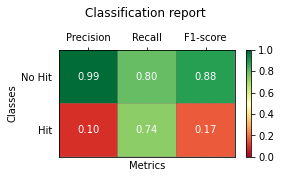

Cohen's kappa coefficient is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.96</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.2</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     138353    35647
Yes Hit      1317     3683



<h3>Running: SMOTE splitting in size 4 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.26
Cohen's kappa coefficient: 0.14


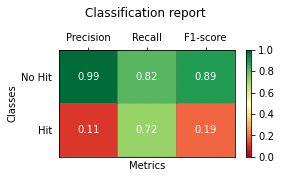

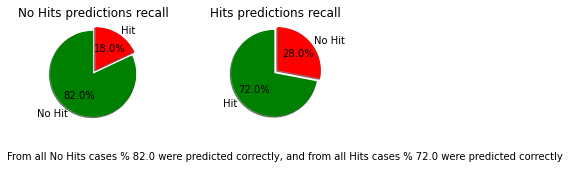

Cohen's kappa coefficient is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.05</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     132126    29874
Yes Hit      1419     3581



<h3>Running: SMOTE splitting in size 5 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.01
Cohen's kappa coefficient: 0.16


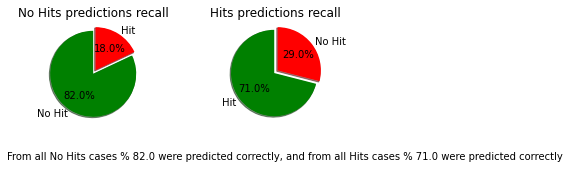

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.3</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     123566    26434
Yes Hit      1444     3556



<h3>Running: SMOTE splitting in size 6 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.15
Cohen's kappa coefficient: 0.17


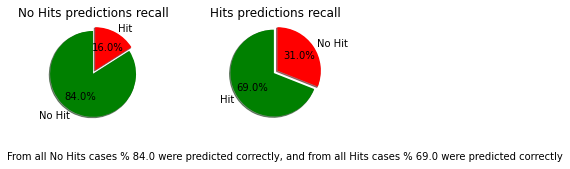

Cohen's kappa coefficient is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.16</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     115471    22529
Yes Hit      1568     3432



<h3>Running: SMOTE splitting in size 7 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.09
Cohen's kappa coefficient: 0.19


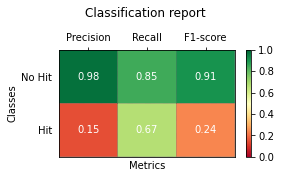

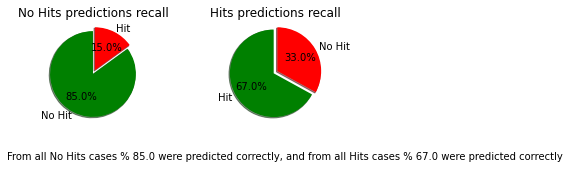

Cohen's kappa coefficient is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.22</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     106814    19186
Yes Hit      1653     3347



<h3>Running: SMOTE splitting in size 8 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.74
Cohen's kappa coefficient: 0.22


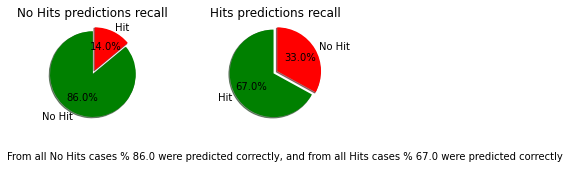

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.57</span> below the baseline.

Hit Precision is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      97505    16495
Yes Hit      1661     3339



<h3>Running: SMOTE splitting in size 9 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.79
Cohen's kappa coefficient: 0.24


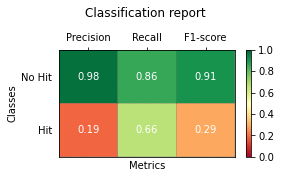

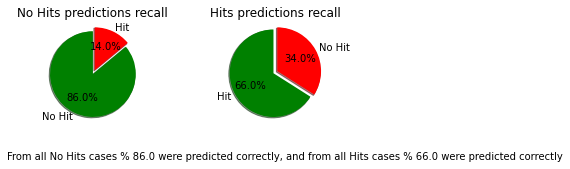

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.52</span> below the baseline.

Hit Precision is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      87412    14588
Yes Hit      1688     3312



<h3>Running: SMOTE splitting in size 10 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.08
Cohen's kappa coefficient: 0.25


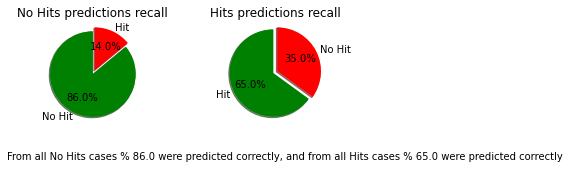

Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.23</span> below the baseline.

Hit Precision is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.65</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      77592    12408
Yes Hit      1769     3231



<h3>Running: SMOTE splitting in size 11 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.49
Cohen's kappa coefficient: 0.28


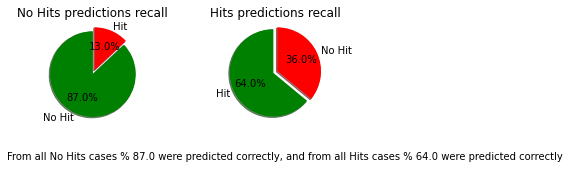

Cohen's kappa coefficient is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.82</span> below the baseline.

Hit Precision is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.64</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      67766    10234
Yes Hit      1812     3188



In [48]:
resampler = SMOTE()
positives = 24
for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: ADASYN splitting in size 2 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %76.61
Cohen's kappa coefficient: 0.10


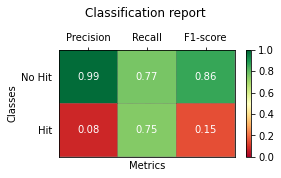

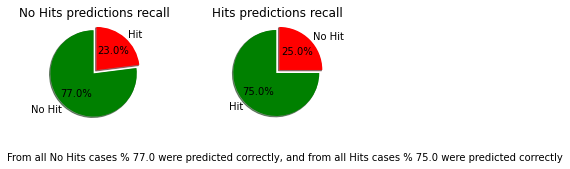

Cohen's kappa coefficient is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -15.7</span> below the baseline.

Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.23</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     142560    43440
Yes Hit      1231     3769



<h3>Running: ADASYN splitting in size 3 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %78.78
Cohen's kappa coefficient: 0.12


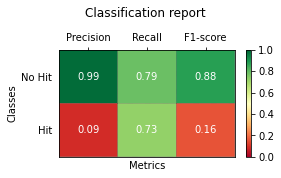

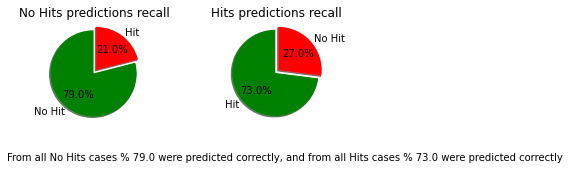

Cohen's kappa coefficient is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -13.53</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.21</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     137342    36658
Yes Hit      1326     3674



<h3>Running: ADASYN splitting in size 4 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.35
Cohen's kappa coefficient: 0.14


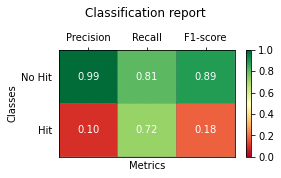

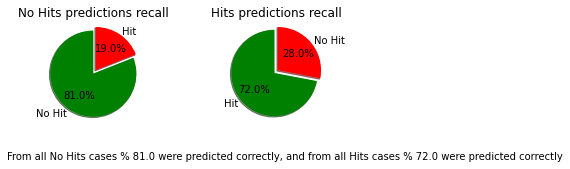

Cohen's kappa coefficient is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.96</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     130567    31433
Yes Hit      1375     3625



<h3>Running: ADASYN splitting in size 5 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.45
Cohen's kappa coefficient: 0.15


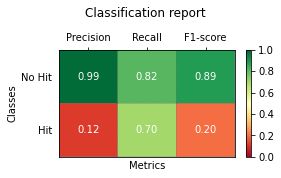

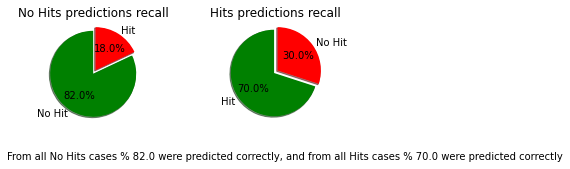

Cohen's kappa coefficient is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.86</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     122726    27274
Yes Hit      1482     3518



<h3>Running: ADASYN splitting in size 6 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.99
Cohen's kappa coefficient: 0.17


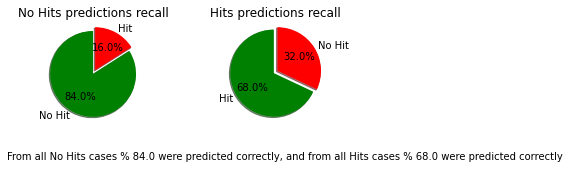

Cohen's kappa coefficient is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.32</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     115249    22751
Yes Hit      1576     3424



<h3>Running: ADASYN splitting in size 7 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.64
Cohen's kappa coefficient: 0.19


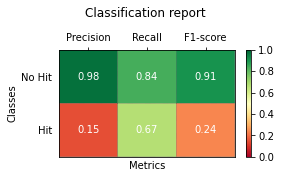

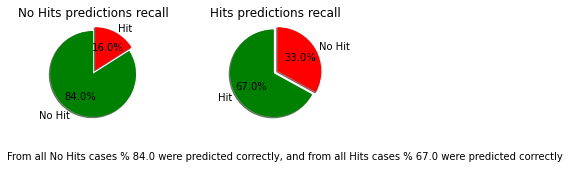

Cohen's kappa coefficient is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.67</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     106211    19789
Yes Hit      1637     3363



<h3>Running: ADASYN splitting in size 8 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.92
Cohen's kappa coefficient: 0.21


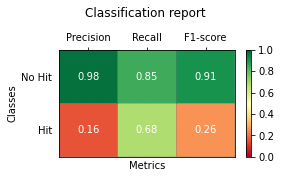

Cohen's kappa coefficient is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.39</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      96466    17534
Yes Hit      1597     3403



<h3>Running: ADASYN splitting in size 9 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.78
Cohen's kappa coefficient: 0.23


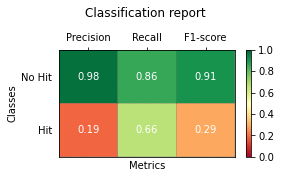

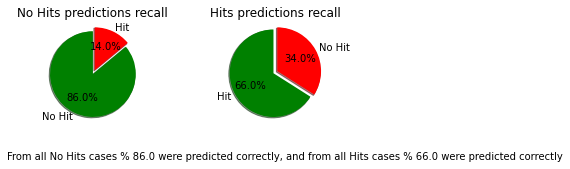

Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.53</span> below the baseline.

Hit Precision is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      87417    14583
Yes Hit      1703     3297



<h3>Running: ADASYN splitting in size 10 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.01
Cohen's kappa coefficient: 0.25


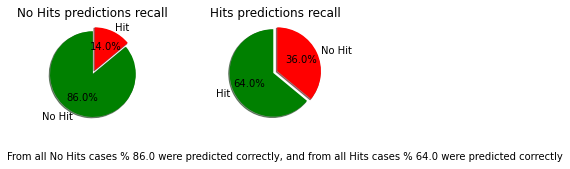

Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.3</span> below the baseline.

Hit Precision is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.64</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      77542    12458
Yes Hit      1784     3216



<h3>Running: ADASYN splitting in size 11 with positives 24</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.38
Cohen's kappa coefficient: 0.29


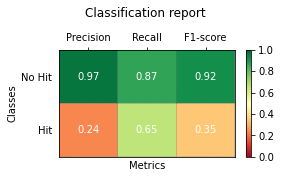

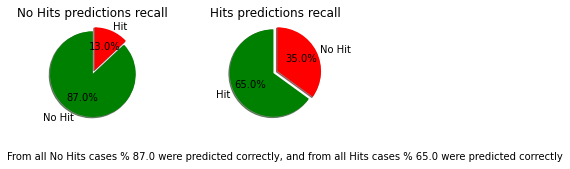

Cohen's kappa coefficient is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.93</span> below the baseline.

Hit Precision is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.65</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      67635    10365
Yes Hit      1766     3234



In [49]:
resampler = ADASYN()
positives = 24

for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: ADASYN splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: SMOTE splitting in size 2 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %75.73
Cohen's kappa coefficient: 0.16


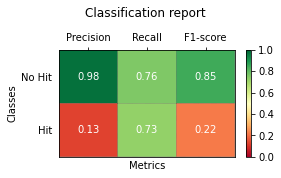

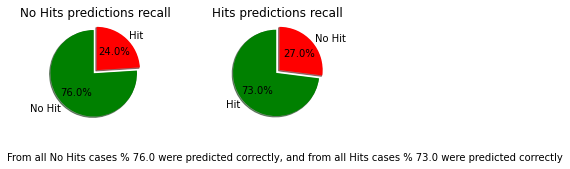

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -16.58</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.24</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     147896    47104
Yes Hit      2533     6967



<h3>Running: SMOTE splitting in size 3 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %78.79
Cohen's kappa coefficient: 0.18


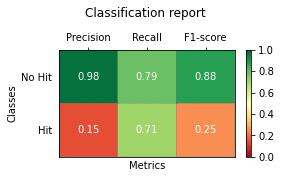

Cohen's kappa coefficient is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -13.52</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.21</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     148442    39058
Yes Hit      2717     6783



<h3>Running: SMOTE splitting in size 4 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.67
Cohen's kappa coefficient: 0.20


Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.64</span> below the baseline.

Hit Precision is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     146247    33753
Yes Hit      2883     6617



<h3>Running: SMOTE splitting in size 5 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.18
Cohen's kappa coefficient: 0.23


Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.13</span> below the baseline.

Hit Precision is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     143092    29408
Yes Hit      3017     6483



<h3>Running: SMOTE splitting in size 6 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.39
Cohen's kappa coefficient: 0.24


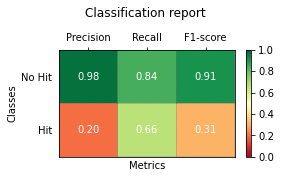

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.92</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     139202    25798
Yes Hit      3189     6311



<h3>Running: SMOTE splitting in size 7 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.99
Cohen's kappa coefficient: 0.26


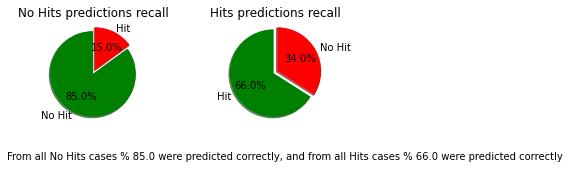

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.32</span> below the baseline.

Hit Precision is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     134005    23495
Yes Hit      3245     6255



<h3>Running: SMOTE splitting in size 8 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.58
Cohen's kappa coefficient: 0.27


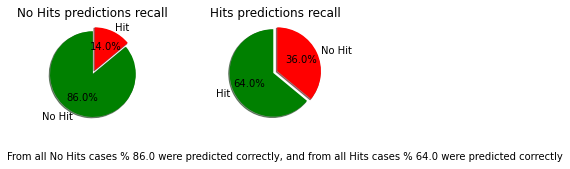

Cohen's kappa coefficient is <span style="color:green"> +0.27</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.73</span> below the baseline.

Hit Precision is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.64</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     128796    21204
Yes Hit      3389     6111



<h3>Running: SMOTE splitting in size 9 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.14
Cohen's kappa coefficient: 0.28


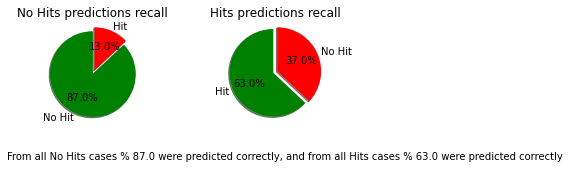

Cohen's kappa coefficient is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.17</span> below the baseline.

Hit Precision is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.63</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     123412    19088
Yes Hit      3493     6007



<h3>Running: SMOTE splitting in size 10 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.55
Cohen's kappa coefficient: 0.30


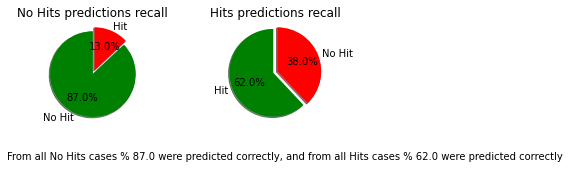

Cohen's kappa coefficient is <span style="color:green"> +0.3</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.76</span> below the baseline.

Hit Precision is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.62</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     117761    17239
Yes Hit      3640     5860



<h3>Running: SMOTE splitting in size 11 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %86.09
Cohen's kappa coefficient: 0.32


Cohen's kappa coefficient is <span style="color:green"> +0.32</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.22</span> below the baseline.

Hit Precision is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.61</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     112100    15400
Yes Hit      3661     5839



In [50]:
resampler = SMOTE()
positives = 15
for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: ADASYN splitting in size 2 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %75.96
Cohen's kappa coefficient: 0.16


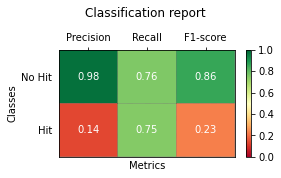

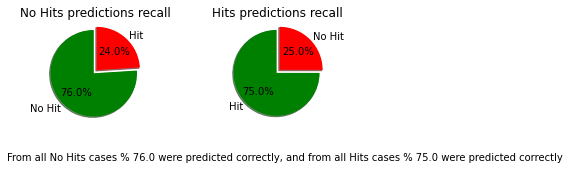

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -16.35</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.24</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     148242    46758
Yes Hit      2399     7101



<h3>Running: ADASYN splitting in size 3 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %78.84
Cohen's kappa coefficient: 0.18


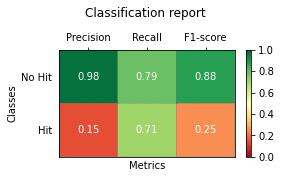

Cohen's kappa coefficient is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -13.47</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.21</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     148549    38951
Yes Hit      2739     6761



<h3>Running: ADASYN splitting in size 4 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.50
Cohen's kappa coefficient: 0.20


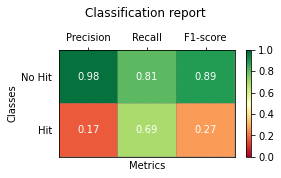

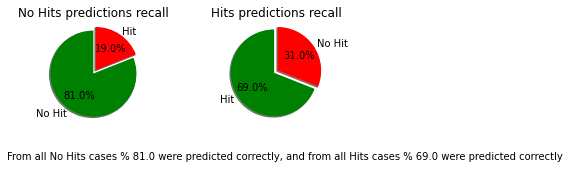

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.81</span> below the baseline.

Hit Precision is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     145954    34046
Yes Hit      2898     6602



<h3>Running: ADASYN splitting in size 5 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.68
Cohen's kappa coefficient: 0.22


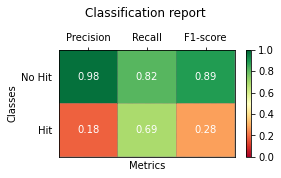

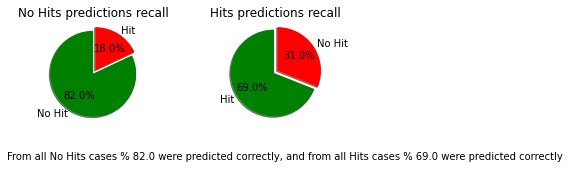

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.63</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     142141    30359
Yes Hit      2977     6523



<h3>Running: ADASYN splitting in size 6 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.66
Cohen's kappa coefficient: 0.24


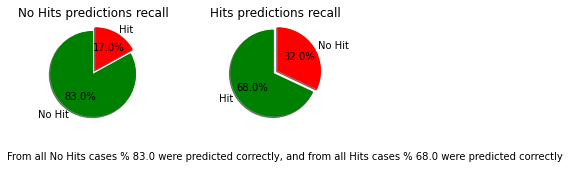

Cohen's kappa coefficient is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.65</span> below the baseline.

Hit Precision is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     137775    27225
Yes Hit      3031     6469



<h3>Running: ADASYN splitting in size 7 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.34
Cohen's kappa coefficient: 0.25


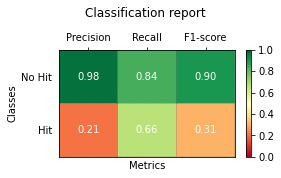

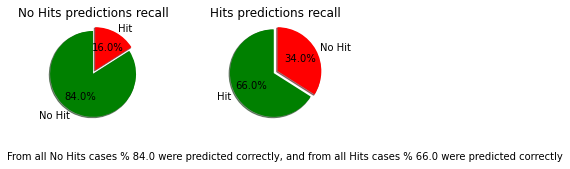

Cohen's kappa coefficient is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.97</span> below the baseline.

Hit Precision is <span style="color:green"> +0.21</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     132866    24634
Yes Hit      3195     6305



<h3>Running: ADASYN splitting in size 8 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.27
Cohen's kappa coefficient: 0.26


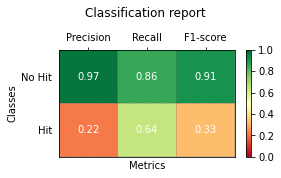

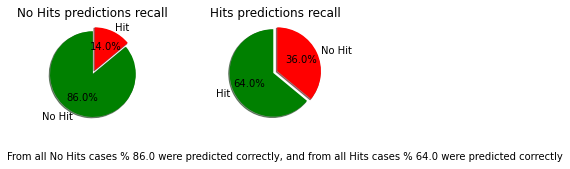

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.04</span> below the baseline.

Hit Precision is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.64</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     128293    21707
Yes Hit      3388     6112



<h3>Running: ADASYN splitting in size 9 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.00
Cohen's kappa coefficient: 0.28


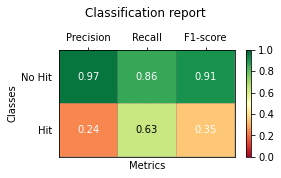

Cohen's kappa coefficient is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.31</span> below the baseline.

Hit Precision is <span style="color:green"> +0.24</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.63</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     123186    19314
Yes Hit      3484     6016



<h3>Running: ADASYN splitting in size 10 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.23
Cohen's kappa coefficient: 0.29


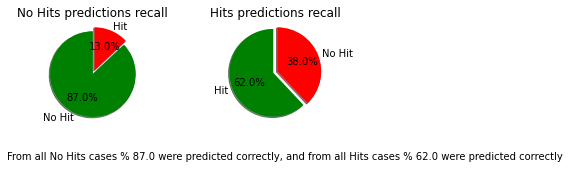

Cohen's kappa coefficient is <span style="color:green"> +0.29</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.08</span> below the baseline.

Hit Precision is <span style="color:green"> +0.25</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.62</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     117225    17775
Yes Hit      3572     5928



<h3>Running: ADASYN splitting in size 11 with positives 15</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.82
Cohen's kappa coefficient: 0.31


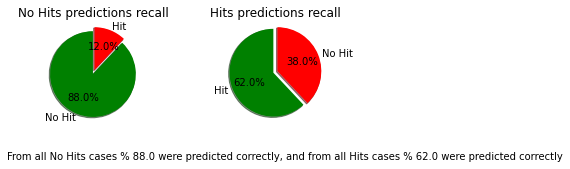

Cohen's kappa coefficient is <span style="color:green"> +0.31</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.49</span> below the baseline.

Hit Precision is <span style="color:green"> +0.28</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.62</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.12</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     111695    15805
Yes Hit      3624     5876



In [51]:
resampler = ADASYN()
positives = 15

for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: ADASYN splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: SMOTE splitting in size 2 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %77.53
Cohen's kappa coefficient: 0.08


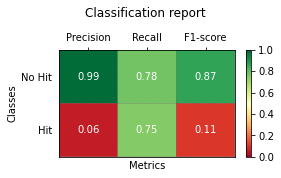

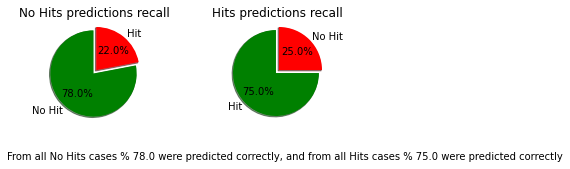

Cohen's kappa coefficient is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -14.78</span> below the baseline.

Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.22</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     141968    41032
Yes Hit       879     2621



<h3>Running: SMOTE splitting in size 3 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %79.66
Cohen's kappa coefficient: 0.10


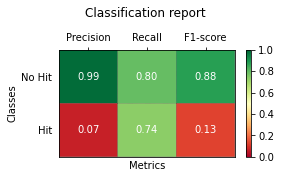

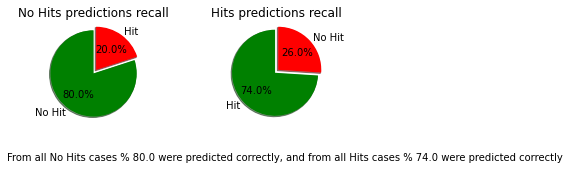

Cohen's kappa coefficient is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.65</span> below the baseline.

Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.2</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135224    34276
Yes Hit       913     2587



<h3>Running: SMOTE splitting in size 4 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.13
Cohen's kappa coefficient: 0.11


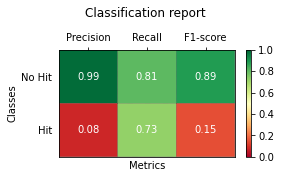

Cohen's kappa coefficient is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.18</span> below the baseline.

Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     126858    29142
Yes Hit       957     2543



<h3>Running: SMOTE splitting in size 5 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.39
Cohen's kappa coefficient: 0.13


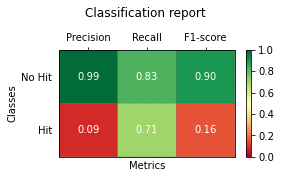

Cohen's kappa coefficient is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.92</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     117811    24689
Yes Hit      1027     2473



<h3>Running: SMOTE splitting in size 6 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.31
Cohen's kappa coefficient: 0.14


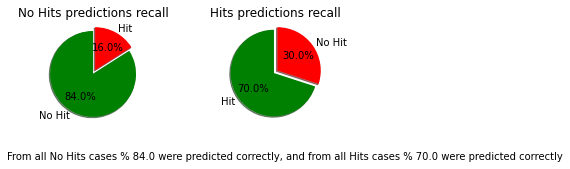

Cohen's kappa coefficient is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.0</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     107932    21068
Yes Hit      1048     2452



<h3>Running: SMOTE splitting in size 7 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.99
Cohen's kappa coefficient: 0.16


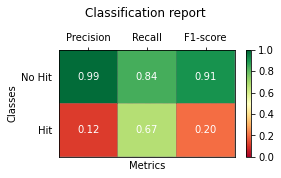

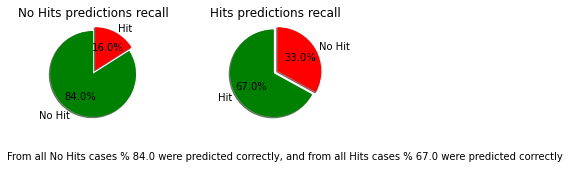

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.32</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      97581    17919
Yes Hit      1138     2362



<h3>Running: SMOTE splitting in size 8 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.71
Cohen's kappa coefficient: 0.18


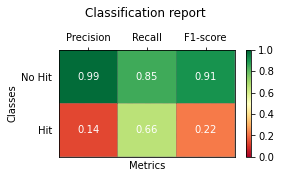

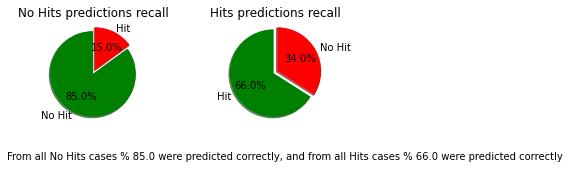

Cohen's kappa coefficient is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.6</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      87057    14943
Yes Hit      1185     2315



<h3>Running: SMOTE splitting in size 9 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.89
Cohen's kappa coefficient: 0.20


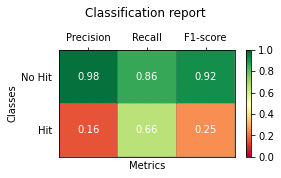

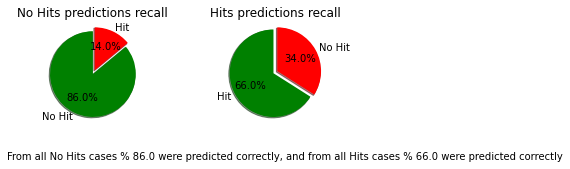

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.42</span> below the baseline.

Hit Precision is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      75800    12700
Yes Hit      1202     2298



<h3>Running: SMOTE splitting in size 10 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.24
Cohen's kappa coefficient: 0.23


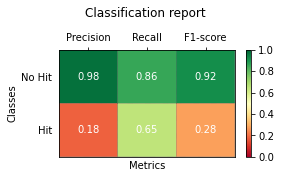

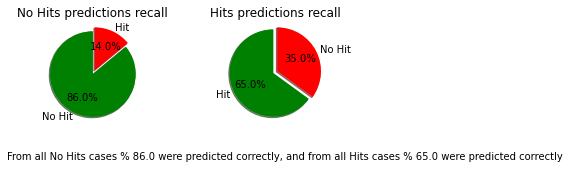

Cohen's kappa coefficient is <span style="color:green"> +0.23</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.07</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.65</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      64656    10344
Yes Hit      1239     2261



<h3>Running: SMOTE splitting in size 11 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.53
Cohen's kappa coefficient: 0.26


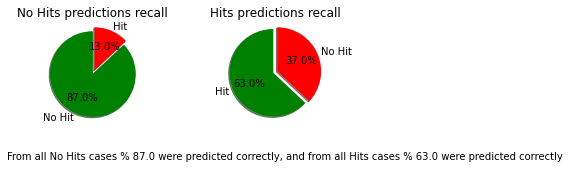

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -6.78</span> below the baseline.

Hit Precision is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.63</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.13</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      53380     8120
Yes Hit      1286     2214



In [52]:
resampler = SMOTE()
positives = 27
for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: ADASYN splitting in size 2 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %77.11
Cohen's kappa coefficient: 0.08


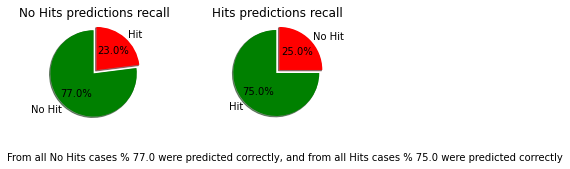

Cohen's kappa coefficient is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -15.2</span> below the baseline.

Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.75</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.23</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     141164    41836
Yes Hit       858     2642



<h3>Running: ADASYN splitting in size 3 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %78.66
Cohen's kappa coefficient: 0.09


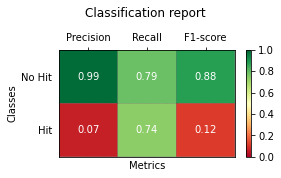

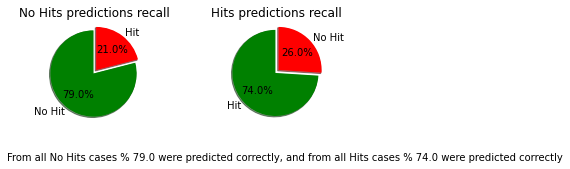

Cohen's kappa coefficient is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -13.65</span> below the baseline.

Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.21</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     133486    36014
Yes Hit       899     2601



<h3>Running: ADASYN splitting in size 4 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.50
Cohen's kappa coefficient: 0.11


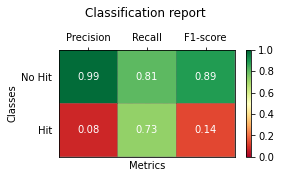

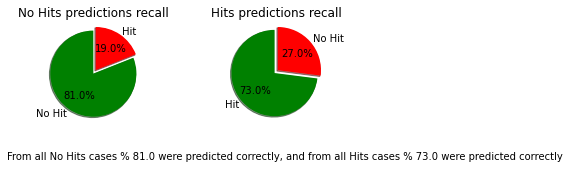

Cohen's kappa coefficient is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.81</span> below the baseline.

Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.73</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     125855    30145
Yes Hit       952     2548



<h3>Running: ADASYN splitting in size 5 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.54
Cohen's kappa coefficient: 0.12


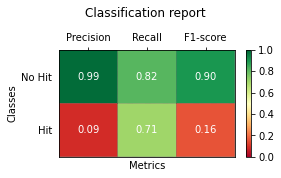

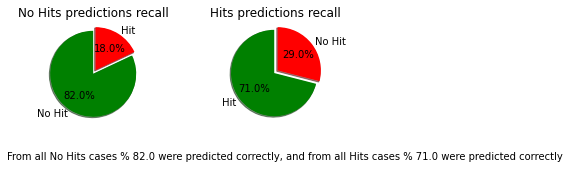

Cohen's kappa coefficient is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -10.77</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.71</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.18</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     116547    25953
Yes Hit      1002     2498



<h3>Running: ADASYN splitting in size 6 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.57
Cohen's kappa coefficient: 0.14


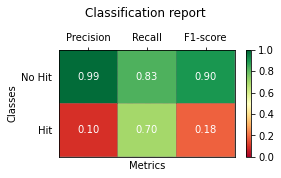

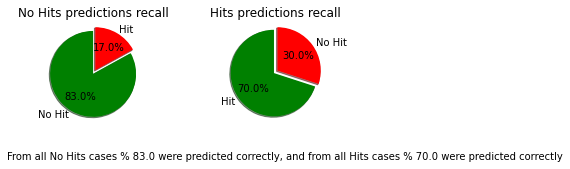

Cohen's kappa coefficient is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.74</span> below the baseline.

Hit Precision is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     106960    22040
Yes Hit      1050     2450



<h3>Running: ADASYN splitting in size 7 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.66
Cohen's kappa coefficient: 0.16


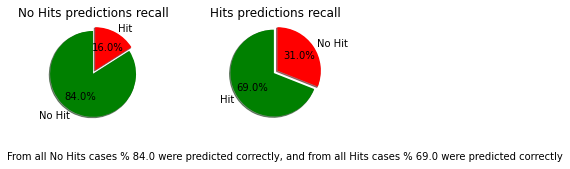

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.65</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      97152    18348
Yes Hit      1094     2406



<h3>Running: ADASYN splitting in size 8 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.09
Cohen's kappa coefficient: 0.17


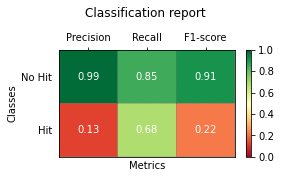

Cohen's kappa coefficient is <span style="color:green"> +0.17</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.22</span> below the baseline.

Hit Precision is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.68</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      86353    15647
Yes Hit      1137     2363



<h3>Running: ADASYN splitting in size 9 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.74
Cohen's kappa coefficient: 0.20


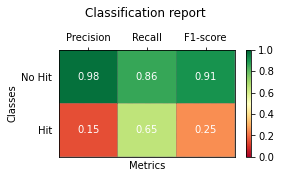

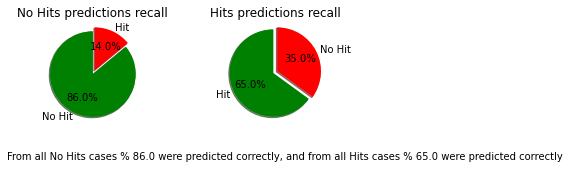

Cohen's kappa coefficient is <span style="color:green"> +0.2</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.57</span> below the baseline.

Hit Precision is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.65</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      75697    12803
Yes Hit      1234     2266



<h3>Running: ADASYN splitting in size 10 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.97
Cohen's kappa coefficient: 0.22


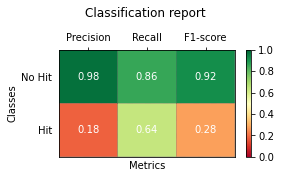

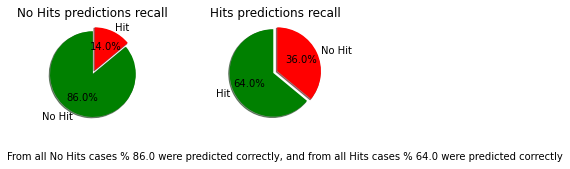

Cohen's kappa coefficient is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.34</span> below the baseline.

Hit Precision is <span style="color:green"> +0.18</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.64</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      64448    10552
Yes Hit      1247     2253



<h3>Running: ADASYN splitting in size 11 with positives 27</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %85.25
Cohen's kappa coefficient: 0.26


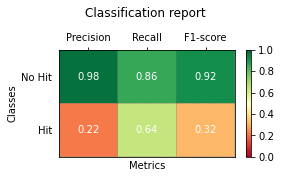

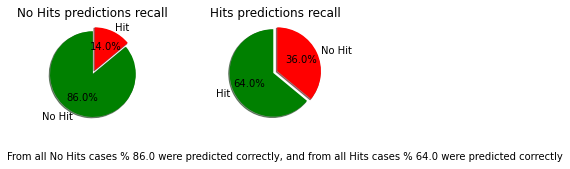

Cohen's kappa coefficient is <span style="color:green"> +0.26</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.06</span> below the baseline.

Hit Precision is <span style="color:green"> +0.22</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.64</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.14</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      53169     8331
Yes Hit      1254     2246



In [53]:
resampler = ADASYN()
positives = 27

for i in range(2,12):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: ADASYN splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)

<h3>Running: SMOTE splitting in size 2 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %77.53
Cohen's kappa coefficient: 0.07


Cohen's kappa coefficient is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -14.78</span> below the baseline.

Hit Precision is <span style="color:green"> +0.05</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.22</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     141195    40805
Yes Hit       768     2232



<h3>Running: SMOTE splitting in size 3 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %80.12
Cohen's kappa coefficient: 0.09


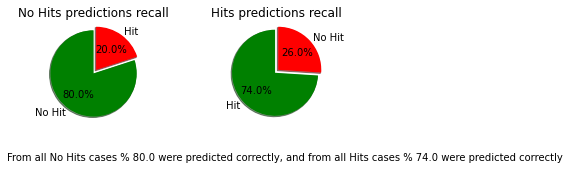

Cohen's kappa coefficient is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -12.19</span> below the baseline.

Hit Precision is <span style="color:green"> +0.06</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.74</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.2</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     134797    33203
Yes Hit       791     2209



<h3>Running: SMOTE splitting in size 4 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %81.22
Cohen's kappa coefficient: 0.10


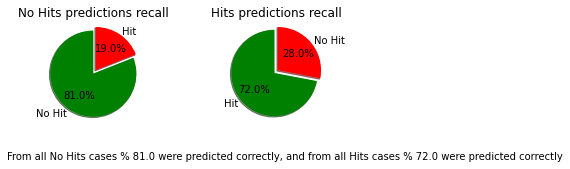

Cohen's kappa coefficient is <span style="color:green"> +0.1</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -11.09</span> below the baseline.

Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.72</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.19</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     125345    28655
Yes Hit       826     2174



<h3>Running: SMOTE splitting in size 5 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %82.48
Cohen's kappa coefficient: 0.11


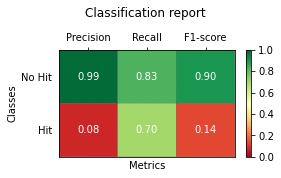

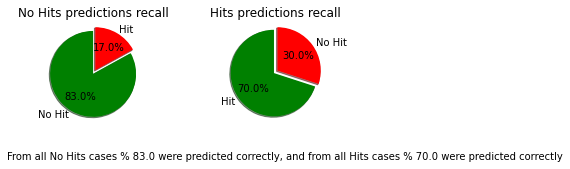

Cohen's kappa coefficient is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.83</span> below the baseline.

Hit Precision is <span style="color:green"> +0.08</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.7</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.17</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     115841    24159
Yes Hit       900     2100



<h3>Running: SMOTE splitting in size 6 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %83.24
Cohen's kappa coefficient: 0.13


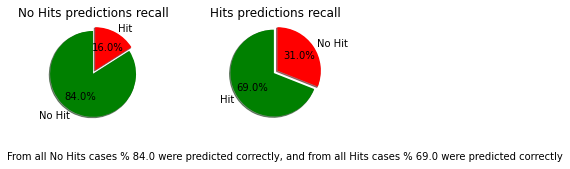

Cohen's kappa coefficient is <span style="color:green"> +0.13</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -9.07</span> below the baseline.

Hit Precision is <span style="color:green"> +0.09</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     105319    20681
Yes Hit       938     2062



<h3>Running: SMOTE splitting in size 7 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.05
Cohen's kappa coefficient: 0.15


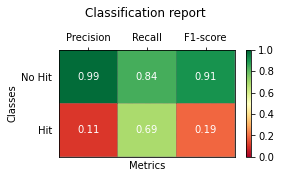

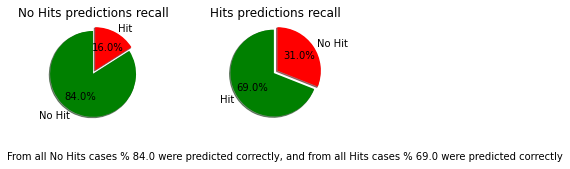

Cohen's kappa coefficient is <span style="color:green"> +0.15</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -8.26</span> below the baseline.

Hit Precision is <span style="color:green"> +0.11</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.69</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.16</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      94592    17408
Yes Hit       933     2067



<h3>Running: SMOTE splitting in size 8 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.61
Cohen's kappa coefficient: 0.16


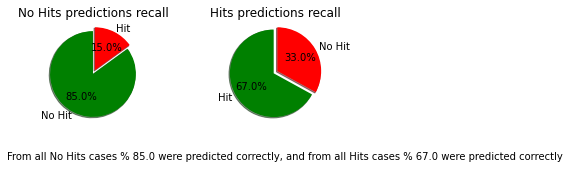

Cohen's kappa coefficient is <span style="color:green"> +0.16</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.7</span> below the baseline.

Hit Precision is <span style="color:green"> +0.12</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.67</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      83444    14556
Yes Hit       983     2017



<h3>Running: SMOTE splitting in size 9 with positives 28</h3>

<h3>Multiple experiments average result:</h3>

Total Accuracy: %84.83
Cohen's kappa coefficient: 0.19


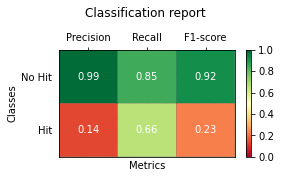

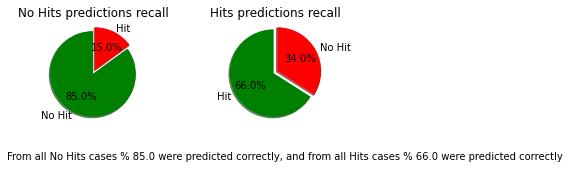

Cohen's kappa coefficient is <span style="color:green"> +0.19</span> above the baseline. 	 <span style="color:green">✓</span>

Total Accuracy percentaje is <span style="color:red">% -7.48</span> below the baseline.

Hit Precision is <span style="color:green"> +0.14</span> above the baseline. 	 <span style="color:green">✓</span>

Hit Recall is <span style="color:green"> +0.66</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Precision is <span style="color:green"> +0.07</span> above the baseline. 	 <span style="color:green">✓</span>

No Hit Recall is <span style="color:red"> -0.15</span> below the baseline.

<h3>Sum of all experiments results:</h3>

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      71805    12195
Yes Hit      1006     1994



In [54]:
resampler = SMOTE()
positives = 28
for i in range(2,10):
    rf_model = RandomForestClassifier(class_weight={0:10, 1:1})

    size = i
    
    print_header("Running: SMOTE splitting in size " + str(size) + " with positives " + str(positives) )


    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 500, positives, resampler_with_split_cases)